<a href="https://colab.research.google.com/github/irislqy/genetic_algorithm/blob/master/Route_Finder_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sources: https://github.com/ezstoltz/genetic-algorithm

##Ingest

In [0]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [0]:
from google.colab import files
uploaded = files.upload()

Saving statelatlong.csv to statelatlong (2).csv


In [0]:
import io
df = pd.read_csv(io.StringIO(uploaded['statelatlong.csv'].decode('utf-8')))



In [0]:
df.head()

,State,Latitude,Longitude,City
0,AL,32.601011,-86.680736,Alabama
1,AK,61.302501,-158.775020,Alaska
2,AZ,34.168219,-111.930907,Arizona
3,AR,34.751928,-92.131378,Arkansas
4,CA,37.271875,-119.270415,California


##Genetic Algorithm

Create class to handle "cities"

In [0]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
      
    def trans(self):
        lst = []
        a = self.x
        b = self.y
        lst.append(a)
        lst.append(b)
        return lst
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
      

Create a fitness function

In [0]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

###Create our initial population


Route generator

In [0]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


Create first "population" (list of routes)

In [0]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

###Create the genetic algorithm

In [0]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [0]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [0]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [0]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [0]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        #print(len(matingpool[i]))
        children.append(matingpool[i])
    
    for i in range(0, length):
        #print(len(pool[i]))
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [0]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [0]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [0]:
def nextGeneration(currentGen, eliteSize, mutationRate):
#     for ele in currentGen:
#       print(len(ele))
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    #print(len(currentGen[0]))
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    #print(len(children[0]))
    nextGeneration = mutatePopulation(children, mutationRate)
    #print(len(nextGeneration[0]))
    return nextGeneration

Final step: create the genetic algorithm

In [0]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
#     for p in pop:
#       print(len(p))
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    #print(len(pop[0]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    #print(len(bestRoute[0]))
    return bestRoute

###Running the genetic algorithm¶

In [0]:
cityList = []

for i in range(0,(len(df)-1)):
    cityList.append(City(x=df['Latitude'][i], y=df['Longitude'][i]))

Run the genetic algorithm

In [0]:
from datetime import datetime
start_time = datetime.now()

# do your work here

route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.005, generations = 200)


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Initial distance: 937.2031667215758
Final distance: 453.63975794234904
Duration: 0:00:09.265658


###Plot the progress¶

In [0]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

generation = 200 seems good enough


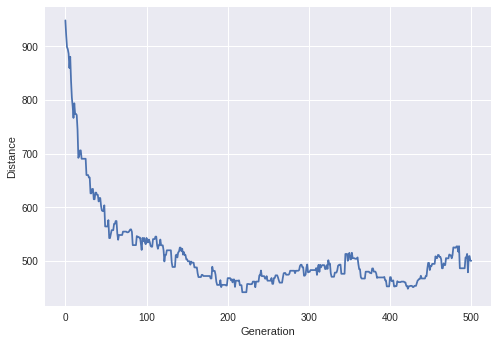

In [0]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=200)

##Translating the Distance

In [0]:
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1.trans()
    lat2, lon2 = coord2.trans()
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/1609

In [0]:
total_distance = 0
for i in range(0,(len(route)-1)):
  distance = haversine(route[i],route[i+1])
  total_distance = total_distance + distance

In [0]:
total_distance

26609.990235158984